In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils import *
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

In [2]:
error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/x.csv')
error_distracted_list, u_signal_distracted_list, x_signal_distracted_list         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDCE/x.csv')

In [3]:
error_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', delimiter=',')
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')
u_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', delimiter=',')
x_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/x.csv', delimiter=',')

In [4]:
person_idx = 0
idx = person_idx*4 + 0

# combine the entire list in the priors
error_not_distracted = np.concatenate(error_not_distracted_list[person_idx])
u_not_distracted = np.concatenate(u_signal_not_distracted_list[person_idx])
x_not_distracted = np.concatenate(x_signal_not_distracted_list[person_idx])

error_distracted = np.concatenate(error_distracted_list[person_idx])
u_distracted = np.concatenate(u_signal_distracted_list[person_idx])
x_distracted = np.concatenate(x_signal_distracted_list[person_idx])

X_not_distracted = np.stack(
    [error_not_distracted, u_not_distracted], axis=-1
)

X_distracted = np.stack([error_distracted, u_distracted], axis=-1)

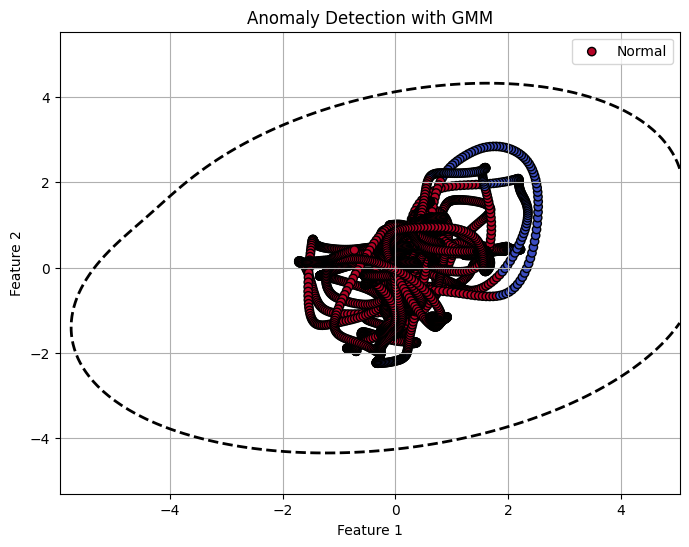

Number of anomalies detected: 5057
[[ 0.19753097  0.75439985]
 [-0.19055266 -0.72774866]]
[[[0.83471209 0.17702311]
  [0.17702311 0.44187463]]

 [[1.08550027 0.13230377]
  [0.13230377 0.45977847]]]


In [5]:
# Fit GMM to the normal data (X_not_distracted)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_not_distracted)

# Compute log-likelihood for all data
log_likelihood = gmm.score_samples(X_distracted)

# Determine anomaly threshold (e.g., 4th percentile of normal data)
threshold = np.percentile(gmm.score_samples(X_not_distracted), 10)

# Classify anomalies
anomalies = log_likelihood < threshold

# Plot results
plt.figure(figsize=(8, 6))

# Plot the first 5000 points of X_distracted, color-coded by anomaly status
plt.scatter(X_distracted[:5000, 0], X_distracted[:5000, 1], c=~anomalies[:5000], cmap='coolwarm', edgecolors='k')

# Plot decision boundary contours
x_min, x_max = X_distracted[:, 0].min() - 1, X_distracted[:, 0].max() + 1
y_min, y_max = X_distracted[:, 1].min() - 1, X_distracted[:, 1].max() + 1

# Create a meshgrid for the feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Evaluate GMM on the grid points
Z = gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour of the decision boundary (threshold)
contour_levels = [np.percentile(Z, 40)]  # Specify a single level (e.g., 4th percentile threshold)
plt.contour(xx, yy, Z, levels=contour_levels, linewidths=2, colors='black', linestyles='dashed')

# Additional plot settings
plt.title('Anomaly Detection with GMM')
plt.legend(['Normal', 'Anomaly'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# print the mean and covariance of the GMM
print(gmm.means_)
print(gmm.covariances_)


In [6]:
# Fit KDE to the normal data (X_not_distracted)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)  # You can tune the bandwidth
kde.fit(X_not_distracted[:10000])

# Evaluate the log-likelihood for all data (X_distracted)
log_likelihood = kde.score_samples(X_distracted)

# Determine anomaly threshold (e.g., 4th percentile of normal data)
threshold = np.percentile(kde.score_samples(X_not_distracted), 4)

# Classify anomalies
anomalies = log_likelihood < threshold

# Evaluate KDE on the grid points
Z = kde.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")


Number of anomalies detected: 3072


In [7]:
# Fit KDE to the normal data (X_not_distracted)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)  # You can tune the bandwidth
kde.fit(X_not_distracted)

# Create a meshgrid for the feature space to evaluate the KDE on
x_min, x_max = X_distracted[:, 0].min() - 1, X_distracted[:, 0].max() + 1
y_min, y_max = X_distracted[:, 1].min() - 1, X_distracted[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Evaluate KDE on the grid points
Z = kde.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot results
plt.figure(figsize=(8, 6))

# Plot the first 5000 points of X_distracted, color-coded by anomaly status
log_likelihood_distracted = kde.score_samples(X_distracted)
threshold = np.percentile(kde.score_samples(X_not_distracted), 4)
anomalies = log_likelihood_distracted < threshold

# # You can adjust the percentage thresholds for anomalies if needed
# plt.scatter(X_distracted[:5000, 0], X_distracted[:5000, 1], c=~anomalies[:5000], cmap='coolwarm', edgecolors='k')



<Figure size 800x600 with 0 Axes>

Percentile 1
Percentile 4
Percentile 10
Percentile 50


/tmp/ipykernel_2417365/3203787567.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[contour_level], linewidths=2, linestyles='dashed', label=f'{p}th percentile')
/tmp/ipykernel_2417365/3203787567.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


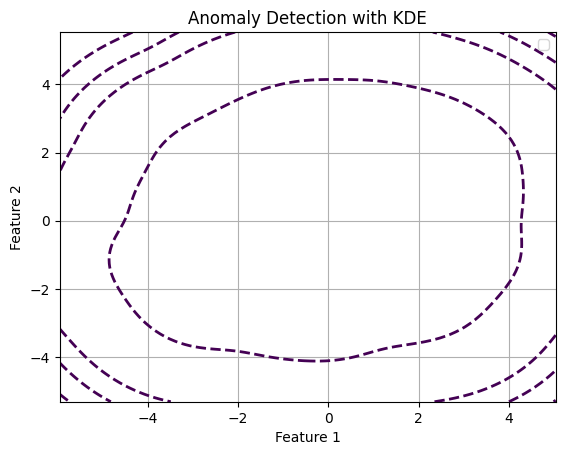

Number of anomalies detected: 3096


In [8]:

# Plot decision boundary contours for different percentiles of the log-likelihood
percentiles = [1, 4, 10, 50]  # List of thresholds (percentiles)
for p in percentiles:
    print(f"Percentile {p}")
    contour_level = np.percentile(Z, p)  # Calculate contour level for each percentile
    plt.contour(xx, yy, Z, levels=[contour_level], linewidths=2, linestyles='dashed', label=f'{p}th percentile')

# Additional plot settings
plt.title('Anomaly Detection with KDE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid()
plt.show()

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")

(480000,)
16106 distracted points
16106 distracted error points
16106 distracted u points
(48000, 2)


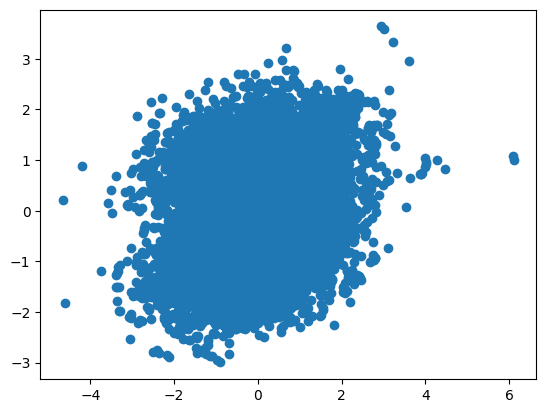

In [9]:
# X_distracted = np.stack([np.concatenate(error_not_distracted_list), np.concatenate(u_signal_not_distracted_list)], axis=-1)

# plot only the points where tc_test == 1
distracted_times = np.where(np.concatenate(tc_test) == 1)[0]
print(f"{np.concatenate(np.concatenate(error_not_distracted_list)).shape}")
distracted_error = np.concatenate(np.concatenate(error_not_distracted_list))[distracted_times]
distracted_u = np.concatenate(np.concatenate(u_signal_not_distracted_list))[distracted_times]

print(f"{distracted_times.shape[0]} distracted points")
print(f"{distracted_error.shape[0]} distracted error points")
print(f"{distracted_u.shape[0]} distracted u points")

print(X_distracted.shape)

plt.scatter(distracted_error, distracted_u)
plt.show()

In [10]:
# Example dataset: 2D points
def compute_density(error_signal_list, u_signal_list, x_signal_list, person_idx, bandwidth=0.2):

    error_signal = np.concatenate(error_signal_list[person_idx])
    u_signal = np.concatenate(u_signal_list[person_idx])
    x_signal = np.concatenate(x_signal_list[person_idx])

    X_data_matrix = np.stack([error_signal, u_signal], axis=-1)

    # Fit a KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)  # Adjust bandwidth for smoothing
    kde.fit(X_data_matrix)

    # Define a grid over the data range
    x_min, x_max = X_data_matrix[:, 0].min() - 1, X_data_matrix[:, 0].max() + 1
    y_min, y_max = X_data_matrix[:, 1].min() - 1, X_data_matrix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    extent = (x_min, x_max, y_min, y_max)

    # Evaluate the KDE on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return density, extent, kde

# Example usage:
person_idx = 1
density, extent,kde = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx)


In [11]:
error_distracted = np.loadtxt(r"/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv", delimiter=',')
u_signal_distracted = np.loadtxt(r"/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv", delimiter=',')
tc_test = np.loadtxt(r"/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv", delimiter=',')

X_distracted = np.stack([error_distracted, u_signal_distracted], axis=1)

In [12]:
import numpy as np
from sklearn.neighbors import KernelDensity
import pickle  # For saving and loading the KDE object


# Function to compute probabilities for new data using the saved KDE
def compute_kde_probabilities(X_test, kde):
    # Compute log densities for the new data
    log_probabilities = kde.score_samples(X_test)
    probabilities = np.exp(log_probabilities)  # Convert log probabilities to probabilities
    
    return probabilities


# Compute probabilities for X_test
all_probabilities = []
for run_idx in range(40):
    print(f"Processing run {run_idx}")
    person_idx = run_idx // 4
    if run_idx % 4 == 0:
        print(f"Processing person {person_idx}")
        density, extent, kde = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx)
    probabilities = compute_kde_probabilities(X_distracted[:,:,run_idx], kde)
    all_probabilities.append(probabilities)


Processing run 0
Processing person 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing person 1
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing person 2
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing person 3
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing person 4
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing person 5
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing person 6
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing person 7
Processing run 29
Processing run 30
Processing run 31
Processing run 32
Processing person 8
Processing run 33
Processing run 34
Processing run 35
Processing run 36
Processing person 9
Processing run 37
Processing run 38
Processing run 39


In [13]:
np.savetxt("all_probabilities.csv", all_probabilities, delimiter=",")

In [16]:
def plot_masked_signal(tc_test, distances):
    """
    Plots the error signal with different colors based on the real label.

    Parameters:
    - tc_test: The true labels array.
    - distances: The distances array.
    """
   
    # Create a mask for tc_test == 1 and tc_test == 0
    mask_1 = tc_test == 1
    mask_0 = tc_test == 0

    print(mask_0)
    print(mask_1)

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.scatter(np.arange(len(distances))[mask_1], distances[mask_1], color='red', label='Distracted')
    plt.scatter(np.arange(len(distances))[mask_0], distances[mask_0], color='blue', label='Not distracted')
    plt.grid()
    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.title('Distances plot with Different Colors Based on mdist (real label)')
    plt.legend()
    plt.show()

# for run_idx in range(40):
#     plot_masked_signal(tc_test[:,run_idx], all_probabilities[run_idx].reshape(-1))

In [18]:
# Example usage:
for person_idx in range(10):
    density, extent, kde = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx, bandwidth=0.15)
    probabilities = compute_kde_probabilities(X_distracted, kde)
    # Save the KDE model to a file
    with open(f'kde_person_{person_idx}.pkl', 'wb') as f:
        pickle.dump(kde, f)

    plot_heatmap(density, extent)


ValueError: Found array with dim 3. KernelDensity expected <= 2.

In [ ]:
def compute_density_for_all(error_signal_list, u_signal_list, x_signal_list):

    error_signal = np.concatenate([np.concatenate(error_signal_list[person_idx]) for person_idx in range(10)])
    u_signal = np.concatenate([np.concatenate(u_signal_list[person_idx]) for person_idx in range(10)])
    # x_signal = np.concatenate(x_signal_list[person_idx])

    X_data_matrix = np.stack([error_signal, u_signal], axis=-1)

    # Fit a KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # Adjust bandwidth for smoothing
    kde.fit(X_data_matrix)

    # Define a grid over the data range
    x_min, x_max = X_data_matrix[:, 0].min() - 1, X_data_matrix[:, 0].max() + 1
    y_min, y_max = X_data_matrix[:, 1].min() - 1, X_data_matrix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    extent = (x_min, x_max, y_min, y_max)

    # Evaluate the KDE on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return density, extent

# Example usage:
person_idx = 1
density, extent = compute_density_for_all(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list)
plot_heatmap(density, extent)

NameError: name 'plot_heatmap' is not defined